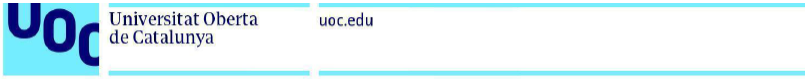

**Asignatura**: Tipología y ciclo de vida de los datos (Máster Ciencia de Datos)

**Dataset**: Para la presente práctica, se ha utilizado la información de los pasajeros del Titanic, disponible en Kaggle. Se ha tomado el conjunto de datos de entrenamiento (train), por tanto trabajamos con una muestra de los pasajeros y no con la población completa (el total de los pasajeros que viajaban en el Titanic).

# Descripción del dataset

¿Por qué es importante y qué pregunta/problema pretende responder?


El Titanic fue un transatlántico británico que se hundió en el Atlántico Norte en la madrugada del 15 de abril de 1912, tras colisionar con un iceberg durante su viaje inaugural de Southampton a Nueva York. Se calcula que había 2224 pasajeros y tripulantes a bordo del barco, y que murieron más de 1500, lo que lo convierte en uno de los desastres marítimos comerciales más grandes de la historia moderna. El Titanic era el mayor barco a flote en el momento en que entró en servicio y fue el segundo de los tres transatlánticos de clase olímpica operados por la White Star Line.

El dataset elegido contiene información demográfica y de los pasajeros de 891 de los 2224 pasajeros y tripulantes a bordo del Titanic. Cabe destacar que el dataset no contiene los datos de todos los pasajeros que abordaron el barco. El dataset de entrenamiento contiene 891 registros. La información contenida en este dataset resulta útil para investigar ls factore que determinaron la probabilidad de supervivencia al hundimiento del Titanic.

Variables:

*   **Survived**: valor booleano que indica si el pasajero sobrevivió o no. El valor 0 indica que no sobrevivió y 1 indica que sí.
*   **Pclass**: Categoría en la que viajaba el pasajero (un proxy de su clase social).
*   **Sex**: sexo del pasajero.
*   **Age**: edad del pasajero.
*   **Sibsp**: número de hermanos o cónyuges a bordo del Titanic.
*   **Parch**: número de padres o hijos a bordo del Titanic.
*   **Ticket**: número de boleto.
*   **Fare**: tarifa del pasajero.
*   **Cabin**: número de cabina.
*   **Embarked**: puerto de embarque.

Puesto que la mayoría de análisis realizados que se pueden encontrar en la web pretenden analizar la probabilidad de supervivencia de los pasajeros, en nuestro caso vamos a tratar de dar respuesta a preguntas del tipo:


*   ¿El lugar en el que embarcó el pasajero tiene relación con el precio del billete?
*   ¿Cuál es la influencia del sexo en el precio del billete?
* ¿Qué influye más en la probabilidad de supervivencia, el precio del billete o la edad del pasajero?


En primer lugar, vamos a importar las librerías que necesitaremos para realizar el ejercicio, así como el conjunto de datos.

In [2]:
import pandas as pd
import numpy as np

# Imputador valores perdidos
from sklearn.impute import KNNImputer

# Tests estadísticos
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm

# Representación gráfica
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Set2")

file_name = "titanic_data.csv"

# Cargamos y mostramos los datos
data = pd.read_csv(file_name)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Integración y selección de los datos de interés a analizar

Pese a que con la información de la cabina posiblemente se podría construir nuevos atributos (feature engineering), en nuestro caso descartaremos tanto el identificador del pasajero y como el de la cabina ya que no aportan valor al análisis.

In [3]:
# Columnas que no son útiles (para descartar)
drop_cols = ["PassengerId", "Cabin"]

data = data.drop(columns = drop_cols)

# Limpieza de datos

En esta etapa, trataremos de realizar imputaciones en aquellos registros con valores ausentes y corregiremos las posibles anomalías (ouliers) que detectemos.

## ¿Los datos contienen ceros o elementos vacíos? ¿Cómo gestionarías cada uno de estos casos?

Podemos utilizar la función *describe* para conocer alguna información básica de cada atributo:

In [45]:
# Podemos mostrar una descripción general del dataset
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Guggenheim, Mr. Benjamin",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,891.0,NaN,NaN,NaN,29.670426,12.908011,0.42,22.0,29.699118,35.0,68.705163
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,1601,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,24.046813,20.481625,0.0,7.9104,14.4542,31.0,65.6344
Embarked,891,3,S,646,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A continuación, vamos a inspeccionar las columnas que tienen valores nulos así como la cantidad de valores nulos por columna.

In [42]:
MissD = pd.DataFrame(data.isna().any())
MissD.columns = ['Valores nulos?']
MissD['Total valores nulos'] = data.isna().sum()
MissD

,Valores nulos?,Total valores nulos
Survived,False,0
Pclass,False,0
Name,False,0
Sex,False,0
Age,False,0
SibSp,False,0
Parch,False,0
Ticket,False,0
Fare,False,0
Embarked,False,0


En el caso de la edad, vemos que tenemos un total de 177 valores nulos, puesto que es un número elevado de registros vamos a realizar una imputación en vez de descartarlos. En concreto, vamos a reemplazar los valores faltantes por el promedio de edad de los datos disponibles.

In [6]:
# Imputación media de edad 
data_alt = data
data['Age'] = data['Age'].fillna(data['Age'].mean())

Alternativamente, podemos utilizar el algoritmo k-nearest neighbors para imputar los valores perdidos de la edad (Age). En este caso se utiliza también la media, pero de los N valores más cercanos.

In [7]:
# k-nearest neighbors para imputar los valore perdidos de Age.
imputer = KNNImputer(n_neighbors=5, weights="uniform")


# Ajustamos el modelo e imputamos los missing values
imputer.fit(data_alt[["Age"]])
data_alt["Age"] = imputer.transform(data_alt[["Age"]]).ravel()

En el caso del puerto de embarque, solo hay dos datos faltantes así que podemos completarlo con el valor más frecuente (moda). Otra aproximación, teniendo en cuenta que son únicamente dos registros, podría ser descartarlos, aunque en nuestro caso hemos preferido no deshacernos de ningún registro puesto que el tamaño inicial de la muestra no es muy elevado.

In [8]:
# Imputación valores nulos Embarked 
data['Embarked']=data['Embarked'].fillna(data['Embarked'].value_counts().index[0])

data['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

Finalmente, volvemos a comprobar que tras las imputaciones no existe ningún atributo con valores nulos.

In [43]:
# vuelvo a comprobar los valores faltantes
MissD=pd.DataFrame(data.isna().any())
MissD.columns=['Valores nulos?']
MissD['Total valores nulos']=data.isna().sum()
MissD

,Valores nulos?,Total valores nulos
Survived,False,0
Pclass,False,0
Name,False,0
Sex,False,0
Age,False,0
SibSp,False,0
Parch,False,0
Ticket,False,0
Fare,False,0
Embarked,False,0


## Identificación y tratamiento de valores extremos

En este apartado trataremos de identificar si existen valores extremos (outliers) y veremos qué tratamiento aplicar a cada uno de ellos.

### Edad

Visualizamos la distribución de los datos a través de un histograma y un boxplot.

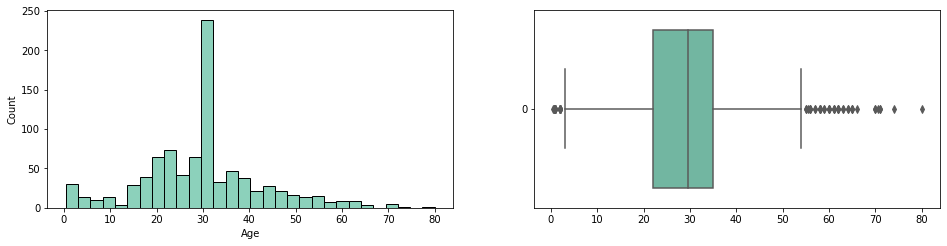

In [10]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(data['Age'])
plt.subplot(2,2,2)
sns.boxplot(data=data['Age'], orient='h')
plt.show()

A partir del boxplot podemos ver que hay algunos valores que podrían interpretarse como outliers. Como la distribución es aproximadamente normal y, además, aplicando el TCL podemos asumir normalidad; vamos a aplicar un método de detección de outliers basado en la ditribución normal:

Aquellos punto que se encuentren por debajo de `mean-3*(sigma)` o por encima de `mean+3*(sigma)` serán considerados outliers y serán reemplazados por el valor límite en cada caso.


In [11]:
upper_limit = data['Age'].mean() + 3*data['Age'].std()
lower_limit = data['Age'].mean() - 3*data['Age'].std()

print(round(upper_limit,0))
print(round(lower_limit,0))

69.0
-9.0


Reemplazamos los valores de los outliers por los nuevos valores que hemos calculados y de nuevo representamos los resultados.

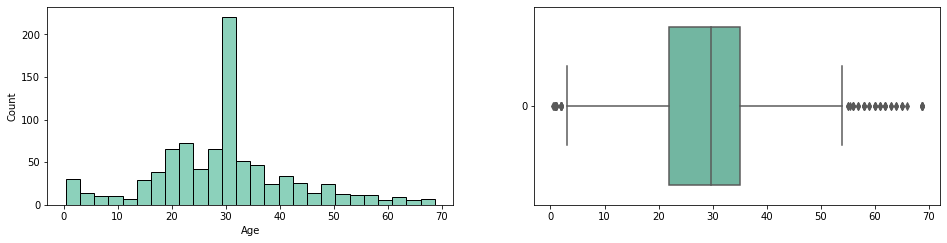

In [12]:
# Imputamos valores a outliers
data['Age'] = np.where(
    data['Age']>upper_limit,
    upper_limit,
    np.where(
        data['Age']<lower_limit,
        lower_limit,
        data['Age']
    )
)

# Volvemos a visualizar los datos corregidos
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(data['Age'])
plt.subplot(2,2,2)
sns.boxplot(data=data['Age'], orient='h')
plt.show()

### Fare

Como en el apartado anterior, visualizamos la distribución de los datos a través de un histograma y un boxplot.

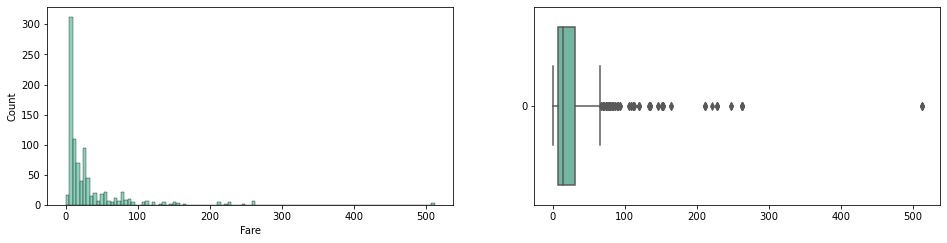

In [13]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(data['Fare'])
plt.subplot(2,2,2)
sns.boxplot(data=data['Fare'], orient='h')
plt.show()

En el caso de la tarifa del boleto vemos, a partir del boxplot, que hay valores muy extremo. Sin embargo, contrariamente a lo que sucedía con la variable edad, en este caso la distribución está sesgada y no parece seguir una normal; por lo cual deberemos aplicar un método distinto. Para estos casos podemos utilizar la regla del rango intercuartílico (IRQ):

Los datos que caen por debajo de `Q1 – 1.5 IQR` o por encima de `Q3 + 1.5 IQR` serán considerado outliers. Q1 y Q3  representan el percentil 25 y 50, respectivamente; y IQR representa el rango intercuartílico calculado como `Q3 – Q1`.

In [14]:
# calculo Q1, Q3 y el IQR

percentile25 = data['Fare'].quantile(0.25)
percentile75 = data['Fare'].quantile(0.75)
iqr=percentile75-percentile25

print(percentile25)
print(percentile75)
print(iqr)

7.9104
31.0
23.0896


De nuevo, imputamos los nuevos valores a los outliers que hemos identificado.

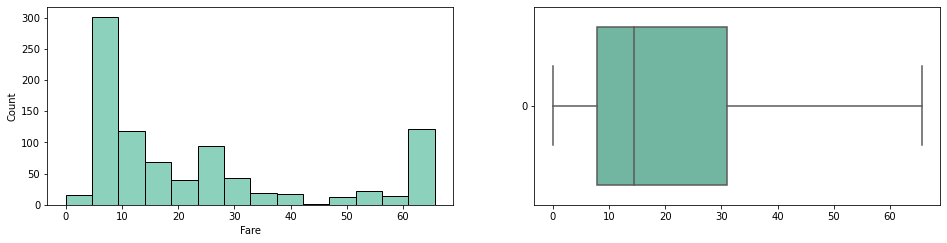

In [15]:
# Calculamos los límites
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# imputación de los datos
data['Fare'] = np.where(
    data['Fare'] > upper_limit,
    upper_limit,
    np.where(
        data['Fare'] < lower_limit,
        lower_limit,
        data['Fare']
    )
)

# Visualizo nuevamente los datos
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(data['Fare'])
plt.subplot(2,2,2)
sns.boxplot(data=data['Fare'], orient='h')
plt.show()

### SibSp y Parch

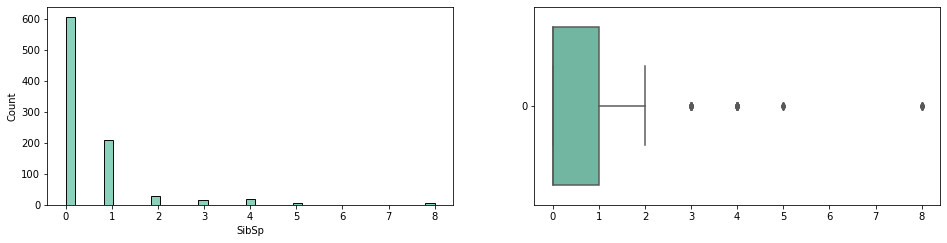

In [16]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(data['SibSp'])
plt.subplot(2,2,2)
sns.boxplot(data=data['SibSp'], orient='h')
plt.show()

In [17]:
data.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

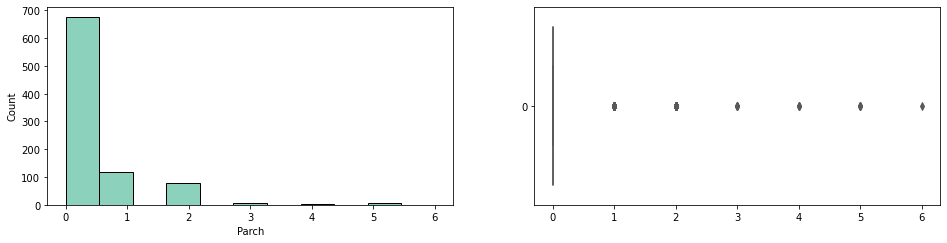

In [18]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(data['Parch'])
plt.subplot(2,2,2)
sns.boxplot(data=data['Parch'], orient='h')
plt.show()

In [19]:
data.Parch.value_counts()

0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

# Análisis de los datos

## Selección de los grupos de datos que se quieren analizar/comparar (planificación de los análisis a aplicar)

En este punto vamos a comparar diferentes grupos de datos.

1. Medidas de tendencia central y dispersión de los atributos numéricos del dataset (Análisis estadístico descriptivo).

2. Analizar si existen diferencias significativas entre el precio medio (*Fare*) de hombres y mujeres (Comparación de dos grupos, análisis estadístico inferencial).

3. Correlación entre la edad y la tarifa (correlación de pearson, análisis estadístico inferencial).

4. Analizar si existen diferencias significativas entre las tarifas (*Fare*) en función del puerto de embarque (*Embarked*) (Comparación de varios grupos, análisis estadístico inferencial).

5. Regresión logística para ver si existe relación entre los grupos supervivientes/fallecidos y la edad y tarifa.

## Comprobación de la normalidad y homogeneidad de la varianza

En primer lugar, vamos a comprobar para los diferentes atributos que vamos a analizar si los valores siguen una distribución normal y si para los diferentes grupos tenemos homogenedidad de varianza (homocedasticidad) o no. 

### Normalidad

- **Tarifa (*Fare*)**: Puesto que p-value es menor que 0.05, podemos rechazar la hipótesis nula H0, por lo que no podemos asumir nomalidad en la distribución de la tarifa (Fare). **No obstante, puesto que el conjunto de datos se compone de un número de registros
suficientemente grande, por el teorema central del límite podemos considerar que los datos siguen una distribución normal**.

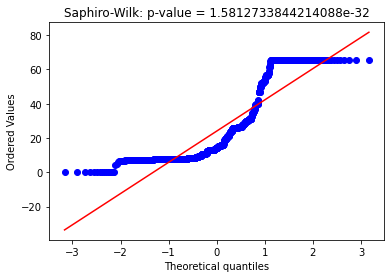

In [20]:
# Tarifa (Fare)
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(data.Fare, plot=ax)

# Test de Shapiro-Wilk -> p-value
p_value = stats.shapiro(data.Fare)[1]

_ = ax.set_title("Saphiro-Wilk: p-value = {}".format(p_value))

- **Edad (*Age*)**: vemos que no podemos asumir normalidad ya que el p-value resultante del test es menor al nivel de significancia (0.05) y por tanto podemos descartar la hipótesis nula de normalidad de los datos. Sin embargo, por el TCL vamos a asumir normalidad.

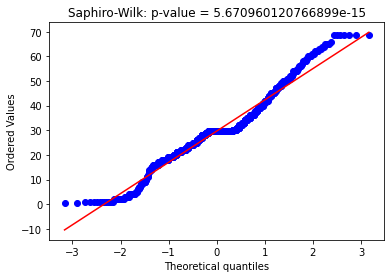

In [21]:
# Edad
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(data.Age, plot=ax)

# Test de Shapiro-Wilk -> p-value
p_value = stats.shapiro(data.Age)[1]

_ = ax.set_title("Saphiro-Wilk: p-value = {}".format(p_value))

### Comprobación homogeneidad de varianzas

*   **Género (*Sex*)**: realizamos el test de Levene para contrastar si existe igualdad de varianza. En este caso obtenemos que p-value < 0.05, por lo que podemos descartar H0 y no asumimos igualdad de varianza.



In [22]:
# Test Levene (asumimos normalidad TCL) para homocedasticidad tarifa según género
stat, p = stats.levene(data.loc[data.Sex == 'female', "Fare"],
                       data.loc[data.Sex == 'male', "Fare"])

# p-value < 0.05 por lo que descartamos H0 y no asumimos igualdad de varianza
p

3.026724076950801e-06

*   **Puerto de embarque (*Embarked*)**: de igual forma que para la variable Sex, realizamos el test de Levene para contrastar si existe igualdad de varianza. En este caso obtenemos que p-value < 0.05, por lo que podemos descartar H0 y no asumimos igualdad de varianza.

In [23]:
# Test Levene (asumimos normalidad TCL) para homocedasticidad tarifa según puerto embarque
stat, p = stats.levene(data.loc[data.Embarked == 'C', "Fare"],
                       data.loc[data.Embarked == 'S', "Fare"],
                       data.loc[data.Embarked == 'Q', "Fare"])

# p-value < 0.05 por lo que descartamos H0 y no asumimos igualdad de varianza
p

1.605467542531367e-15

## Aplicación de pruebas estadísticas para comparar los grupos de datos.

En función de los datos y el objetivo del estudio, aplicar pruebas de contraste de hipótesis, correlaciones, regresiones, etc. Aplicar al menos tres métodos de análisis diferentes.

### Tendencia central y dispersión.

Un primer análisis estadístico preliminar que nos ayuda a entender los atributos numéricos son las medidas de tendencia central (como por ejemplo la media o la mediana) y de dispersión (como por ejemplo la desviación estándar, varianza e IQC).

In [24]:
# Resumen de los principales estadísticos (cuartiles, media, desviación estándar, min. y máx.)
data[["Age", "Fare"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,891.0,29.670426,12.908011,0.42,22.0000,29.699118,35.0,68.705163
Fare,891.0,24.046813,20.481625,0.00,7.9104,14.454200,31.0,65.634400


Vemos que la edad (Age) media de los pasajeros es de 29.7 años, con una desviación estándar de 12.9 años. El pasajero más mayor tenía 68 años.

Respecto a la tarifa (Fare), el valor medio es de 24.04, con una desviación estándar de 20.4, lo que nos da a entender que las variaciones entre los precios que pagaron los diferentes pasajeros está muy dispersa.

### Precio medio billete (Fare) de hombres y mujeres.

Hemos visto que podemos asumir normalidad por el TCL, pero tenemos heterocedasticidad, por lo que aplicamos test de Mann-Whitney (tipo no paramétrico) para ver si existen diferencias significativas entre el precio medio del billete para hombres y mujeres.



In [25]:
res = stats.mannwhitneyu(data.loc[data.Sex == 'female', "Fare"],
                       data.loc[data.Sex == 'male', "Fare"])

# p-value < 0.05 por lo que podemos descartar H0, concluyendo diferencias significativas
# del precio medio del billete entre hombres y mujeres.
res.pvalue

7.0751625976690705e-15

Puesto que el p-value < 0.05 podemos descartar H0, concluyendo diferencias significativas del precio medio del billete entre hombres y mujeres.

### Correlación entre la edad y tarifa.


Vemos que la correlación entre la edad (Age) y la tarifa (Fare) no es muy fuerte. Esto se desprende de que el valor de correlación que obtenemos se aleja de +1 o -1, situándose en este caso cercano al cero.

In [44]:
cor_matrix = data[["Age", "Fare"]].corr(method="pearson")
cor_matrix

,Age,Fare
Age,1.000000,0.138454
Fare,0.138454,1.000000


### Diferencias significativas entre las tarifas (Fare) en función del puerto de embarque (Embarked).

Asumimos normalidad en los datos (TCL) y tenemos heterocedasticidad, por lo que podemos aplicar el test de Kruskal-Wallis para comparar los tres grupos (prueba no paramétrica).

In [27]:
res = stats.kruskal(data.loc[data.Embarked == 'C', "Fare"],
                   data.loc[data.Embarked == 'S', "Fare"],
                   data.loc[data.Embarked == 'Q', "Fare"])


res.pvalue

1.223021894742521e-16

Ya que p-value < 0.05 podemos descartar la hipótesis nula H0, concluyendo que existen diferencias en el precio medio del billete en función del puerto de embarque.

### Regresión logística para ver si existe relación entre los grupos supervivientes/fallecidos frente a la edad y tarifa.

En base a los resultados de los modelos creados, vemos que la variable edad (*Age*) explica peor si un individuo sobrevive o no al accidente que el precio del billete (*Fare*). Usando la combinación de ambas, el valor del test AIC se reduce y por tanto el modelo mejora, aunque ligeramente.

In [28]:
glm_age = glm("Survived ~ Age", data=data, family=sm.families.Binomial()).fit()
glm_fare = glm("Survived ~ Fare", data=data, family=sm.families.Binomial()).fit()
glm_conjunta = glm("Survived ~ Fare + Age", data=data, family=sm.families.Binomial()).fit()

print("AIC Age: {}\n AIC Fare: {}\n AIC Fare + Age: {}"\
      .format(glm_age.aic, glm_fare.aic, glm_conjunta.aic))

AIC Age: 1186.1836099093052
 AIC Fare: 1101.47882232241
 AIC Fare + Age: 1090.4586897743307


# Representación de los resultados

A continuación vamos a representar los valores de los análisis realizados en el punto anterior.

## Tendencia central y dispersión

Para las medidas de la tendencia central y dispersión de las variables cuantitativas (Fare y Age), vamos a representar un boxplot que nos ayuda a entender de una forma fácilmente interpretable cómo se distribuye el valor de ambos atributos a lo largo de nuestra muestra.

Text(0.5, 0, 'Boxplot Tarifa (Fare)')

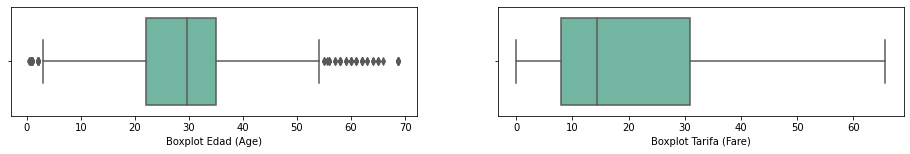

In [41]:
# Tendencia central y dispersión.
fig, axs = plt.subplots(1, 2, figsize=(16, 2))

sns.boxplot(x="Age", data=data, ax=axs[0])
sns.boxplot(x="Fare", data=data, ax=axs[1])

axs[0].set_xlabel("Boxplot Edad (Age)")
axs[1].set_xlabel("Boxplot Tarifa (Fare)")

## Precio del billete según el Sexo

Como hemos visto con la realización del test, tenemos diferencias significativas en el precio medio del billete entre hombres y mujeres.

Text(0.5, 1.0, 'Boxplot tarifa por sexo')

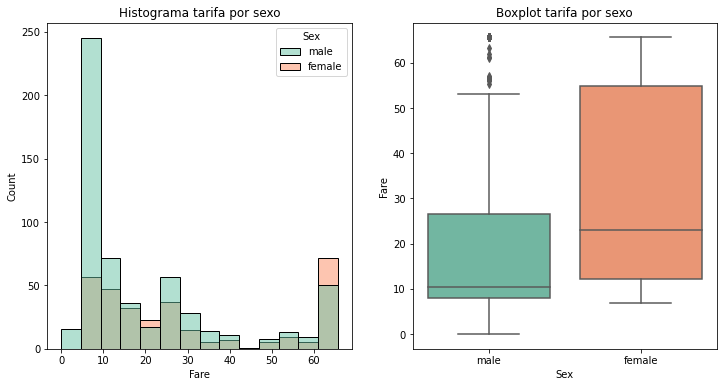

In [30]:
# Precio del billete según el Sexo
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(x="Fare", hue="Sex", data=data, ax=axs[0])
sns.boxplot(x="Sex", y="Fare", data=data, ax=axs[1])

axs[0].set_title("Histograma tarifa por sexo")
axs[1].set_title("Boxplot tarifa por sexo")

## Correlación Edad y Tarifa

Podemos realizar un scatter plot (gráfico de dispersión) para ver si se intuye alguna relación en los datos entre el precio del billete (Fare) y la edad del pasajero. 

Text(0.5, 1.0, 'Scatter plot Tarifa vs Edad')

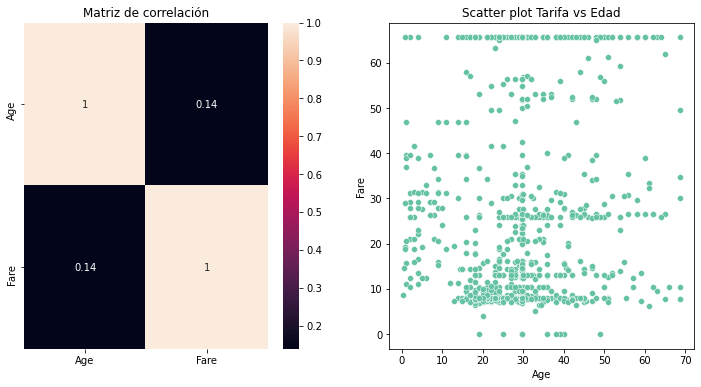

In [33]:
# Correlación y dispersión
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(cor_matrix, annot=True, ax=axs[0])
sns.scatterplot(x="Age", y="Fare", data=data, ax=axs[1])

axs[0].set_title("Matriz de correlación")
axs[1].set_title("Scatter plot Tarifa vs Edad")

Podemos identificar cierta concentración de observaciones en la franja de edad 20 - 40 años que han pagado una tarifa entre 10 y 20, sin embargo no vemos que exista una fuerte correlación entre ambos atributos.

## Precio del billete según puerto de embarque.

Con la representación gráfica de los resultados, al igual que hicimos con el test, podemos ver si existen diferencias significativas en el precio del billete (Fare) según el puerto de embarque. 

Text(0.5, 1.0, 'Boxplot tarifa por puerto de embarque')

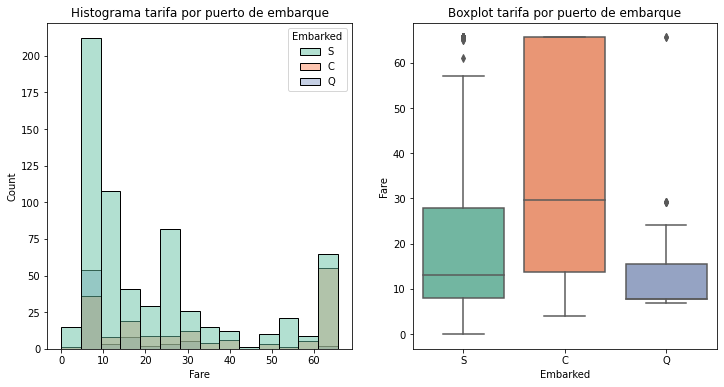

In [34]:
# Precio del billete según puerto de embarque.
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(x="Fare", hue="Embarked", data=data, ax=axs[0])
sns.boxplot(x="Embarked", y="Fare", data=data, ax=axs[1])

axs[0].set_title("Histograma tarifa por puerto de embarque")
axs[1].set_title("Boxplot tarifa por puerto de embarque")

Podemos ver a simple vista (confirmado con el test que hemos realizado anteriormente), que existen diferencias significativas en el precio medio del billete en función del puerto de embarque del pasajero, siendo el precio medio del billete más alto para los que han embarcado en 'C'.

# Resolución del problema

Con el análisis que hemos realizado, podemos dar respuesta a las preguntas que se plantearon al inicio, en particular, sabemos que el precio medio del billete varía significativamente en función de los valores de los atributos de cada pasajero, **siendo el precio medio superior (casi tres veces) para aquellos pasajeros que embarcaron en Cherbourg**. 

También hemos podido averiguar que **las mujeres pagaron de media casi el doble del precio medio de los billetes de los hombres.** Adicionalmente, hemos tratado de identificar si existe correlación entre la edad y la tarifa, concluyendo que no existe una relación fuerte entre ambos atributos.

Una vez analizado el precio del billete y las diferencias entre grupos de individuos, hemos puesto el foco en la posibilidad de supervivencia tras el hundimiento, analizando qué factor tenía más relación con la supervivencia, deduciendo que **el precio del billete explica mejor que la edad si un individuo sobrevive al accidente o no.**

# Código

El código, así como el conjunto de datos que se ha empleado para la elaboración de la práctica se puede encontrar en el siguiente repositorio de GitHub: https://github.com/ntaxus/LIMPIEZA-DE-DATOS

# Vídeo

El video explicativo se encuentra en el siguiente enlace: 